In [42]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
from matplotlib import gridspec

import uproot3 as uproot

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [43]:
from scipy.stats import norm, chisquare 
from scipy.optimize import curve_fit, leastsq
from scipy.special import logit

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, accuracy_score, f1_score

#import xgboost as xgb
#from xgboost import XGBClassifier

### Fit Pi0 Mass Peak

In [44]:
def fit_function(x, A, B, mu, sigma):
    return (A + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

def ff(x, p):
    return fit_function(x, *p)

def fit_curvefit(p0, datax, datay, function, yerr, **kwargs):
    pfit, pcov = curve_fit(fit_function, datax, datay, p0=p0, sigma=yerr, **kwargs)
    
    errfunc = lambda p, x, y: function(x,p) - y
    residuals = errfunc(pfit, datax, datay)
    chisq = sum([(x/y)**2 for x,y in zip(residuals, yerr)])
    dof = len(datax)-1-len(p0) # nbins - constrain on sum of events in bins - nparams
    chisq_red = chisq/dof
    
    error = [] 
    for i in range(len(pfit)):
        try: error.append(np.absolute(pcov[i][i])**0.5)
        except: error.append( 0.00 )
    pfit_curvefit = [round(x,3) for x in list(pfit)]
    perr_curvefit = [round(x,3) for x in error]
    return pfit_curvefit, perr_curvefit, chisq, chisq_red

In [45]:
bins_ = np.linspace(5.882353,394.1176,34)
x_center = [5.882353, 17.64706, 29.41176, 41.17647, 52.94118, 64.70588, 76.47059, 88.23529, 100, 111.7647, 
            123.5294, 135.2941, 147.0588, 158.8235, 170.5882, 182.3529, 194.1176, 205.8824, 217.6471, 229.4118, 
            241.1765, 252.9412, 264.7059, 276.4706, 288.2353, 300, 311.7647, 323.5294, 335.2941, 347.0588, 358.8235, 
            370.5882, 382.3529, 394.1176]
xerr = [5.882353]*len(x_center)

data_FC0p = [66, 96, 106, 102, 131, 125, 153, 172, 160, 228, 252, 313, 277, 151, 115, 
             67, 52, 41, 37, 28, 22, 27, 27, 17, 12, 16, 15, 10, 14, 8, 10, 13, 9, 2]
yerr_FC0p = [np.sqrt(x) for x in data_FC0p]

data_FCNp = [64, 68, 72, 77, 81, 74, 113, 81, 140, 202, 228, 297, 203, 81, 59, 23, 21, 17, 16, 15, 11, 15, 8, 8, 3, 5, 7, 8, 3, 4, 2, 4, 2, 2]
yerr_FCNp = [np.sqrt(x) for x in data_FCNp]

In [64]:
def fit_mass_peak(bins_, xerr, data_NC, yerr_NC):
    range_left = 110
    range_right = 180
    ix = np.where((bins_ >= range_left) & (bins_ <= range_right))

    data_hist_range = np.asarray(data_NC)[ix]
    err_bar_range = np.asarray(yerr_NC)[ix]
    mid_range = np.asarray(bins_)[ix]

    pfit, perr, chisq, chisq_red = fit_curvefit([10, 2.0, 140, 3.0], mid_range, data_hist_range, ff, err_bar_range)

    print("\n# Fit parameters and parameter errors from curve_fit method :")
    print("pfit = ", pfit)
    print("perr = ", perr)
    print("chisq = ", chisq)
    print("chisq_red = ", chisq_red)

    plt.figure(figsize=(9,6))
    #plt.title('NC (Data)')
    plt.errorbar(bins_, data_NC, xerr=xerr, yerr=yerr_NC, color='black', label='BNB Data', fmt='o')
    plt.plot(np.linspace(range_left,range_right,1000), fit_function(np.linspace(range_left,range_right,1000), *pfit), color='lime', linewidth=2.5, label=r'Fit')
    plt.vlines(134.98, 0, max(data_NC)+5, ls='--', color='red', label=r'$\pi^{0}$ mass: 134.98 MeV/$c^2$', alpha=0.5)
    plt.xlabel(r'$\pi^{0}$ mass [MeV]')
    plt.ylim(0,400)
    plt.xlim(0,400)
    plt.legend(loc='best')
    plt.show()


# Fit parameters and parameter errors from curve_fit method :
pfit =  [76.672, 228.302, 132.406, 19.706]
perr =  [79.432, 72.432, 2.901, 7.867]
chisq =  10.866954947019687
chisq_red =  10.866954947019687


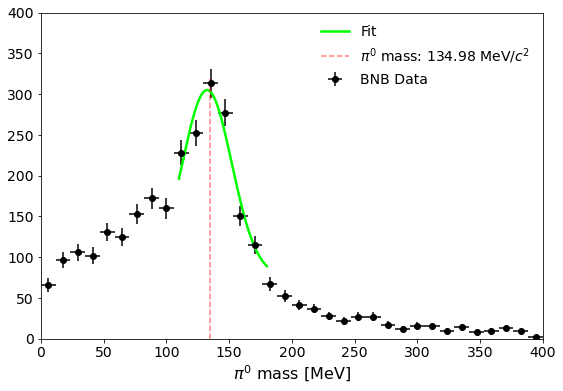

In [65]:
fit_mass_peak(bins_, xerr, data_FC0p, yerr_FC0p)


# Fit parameters and parameter errors from curve_fit method :
pfit =  [39.613, 242.523, 129.765, 17.167]
perr =  [39.902, 44.493, 2.88, 4.79]
chisq =  16.797692030194924
chisq_red =  16.797692030194924


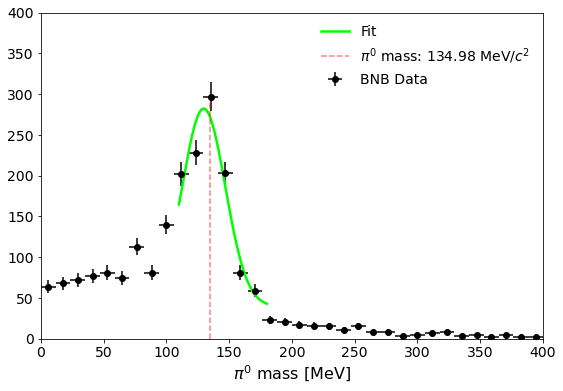

In [66]:
fit_mass_peak(bins_, xerr, data_FCNp, yerr_FCNp)


# Fit parameters and parameter errors from curve_fit method :
pfit =  [88.94, 759.912, 131.323, -22.093]
perr =  [190.534, 178.118, 0.765, 4.729]
chisq =  5.344242874364695
chisq_red =  2.6721214371823474


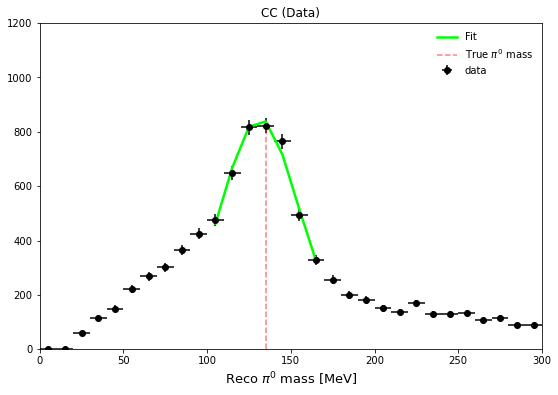

In [11]:
range_left = 100
range_right = 170
ix = np.where((bins_ >= range_left) & (bins_ <= range_right))

data_hist_range = np.asarray(data_CC)[ix]
err_bar_range = np.asarray(yerr_CC)[ix]
mid_range = np.asarray(bins_)[ix]

pfit, perr, chisq, chisq_red = fit_curvefit([10, 2.0, 140, 3.0], mid_range, data_hist_range, ff, err_bar_range)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)
print("chisq = ", chisq)
print("chisq_red = ", chisq_red)

plt.figure(figsize=(9,6))
plt.title('CC (Data)')
plt.errorbar(bins_, data_CC, xerr=xerr, yerr=yerr_CC, color='black', label='data', fmt='o')
plt.plot(bins_[ix], fit_function(bins_[ix], *pfit), color='lime', linewidth=2.5, label=r'Fit')
plt.vlines(134.9766, 0, max(data_CC)+5, ls='--', color='red', label=r'True $\pi^{0}$ mass', alpha=0.5)
plt.xlabel(r'Reco $\pi^{0}$ mass [MeV]')
plt.ylim(0,1200)
plt.xlim(0,300)
plt.legend(loc='best')
plt.show()

In [26]:
bins_ = np.linspace(5,295,30)
xerr = [5.]*len(bins_)

data_mcNC = [0., 0., 100.3803, 150.0397, 156.0427, 180.9812, 224.8004, 248.7306, 271.0999, 303.514, 429.3403, 458.6293, 
             543.0247, 569.9306, 543.5509, 458.3569, 277.0392, 226.0203, 197.377, 177.6388, 145.8653, 138.9565, 134.4701, 121.9106, 
             110.0861, 99.44955, 94.64713, 83.18024, 79.95753, 64.38483] 

yerr_mcNC = [0.4535019, 0.4535019, 36.63803, 44.19594, 42.52787, 48.35177, 51.9165, 67.81861, 65.15279, 75.39145, 120.5057, 
             118.1414, 139.6857, 189.112, 148.0611, 131.4847, 138.1231, 89.9615, 52.80616, 47.0251, 40.08315, 37.54154, 56.37934, 39.71024, 
             36.69175, 45.72668, 36.51028, 34.79906, 28.35465, 24.85699]

data_mcCC = [0., 0., 60.3772, 100.3893, 157.0783, 195.2184, 244.2996, 310.3976, 359.4898, 449.377, 
             569.1998, 728.6938, 849.6064, 938.5095, 807.0377, 575.2731, 355.9426, 290.4313, 244.1264, 218.6381, 
             188.4615, 160.847, 172.048, 164.0868, 137.7923, 130.3537, 127.0289, 114.8171, 105.4315, 95.60645]

yerr_mcCC = [0.4535019, 0.4535019, 29.43977, 40.25252, 55.5265, 58.82391, 70.453, 85.56042, 104.1666, 
             154.0223, 195.9783, 248.0774, 251.9348, 247.5929, 217.9884, 209.4935, 253.9613, 83.91001, 73.45402, 
             63.53231, 56.54557, 46.51371, 75.26633, 64.63671, 48.73464, 46.74337, 68.02377, 45.43895, 40.778, 56.67549]


# Fit parameters and parameter errors from curve_fit method :
pfit =  [234.258, 341.355, 132.054, -21.458]
perr =  [45.945, 42.889, 1.865, 4.119]
chisq =  0.47618715485116114
chisq_red =  0.11904678871279029


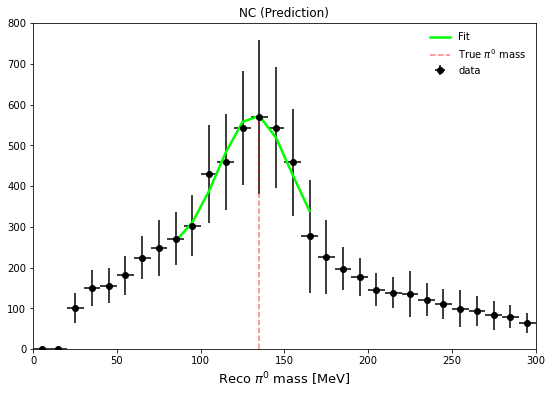

In [29]:
range_left = 80
range_right = 170
ix = np.where((bins_ >= range_left) & (bins_ <= range_right))

data_hist_range = np.asarray(data_mcNC)[ix]
err_bar_range = np.asarray(yerr_mcNC)[ix]
mid_range = np.asarray(bins_)[ix]

pfit, perr, chisq, chisq_red = fit_curvefit([10, 2.0, 140, 3.0], mid_range, data_hist_range, ff, err_bar_range)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)
print("chisq = ", chisq)
print("chisq_red = ", chisq_red)

plt.figure(figsize=(9,6))
plt.title('NC (Prediction)')
plt.errorbar(bins_, data_mcNC, xerr=xerr, yerr=yerr_mcNC, color='black', label='data', fmt='o')
plt.plot(bins_[ix], fit_function(bins_[ix], *pfit), color='lime', linewidth=2.5, label=r'Fit')
plt.vlines(134.9766, 0, max(data_mcNC)+5, ls='--', color='red', label=r'True $\pi^{0}$ mass', alpha=0.5)
plt.xlabel(r'Reco $\pi^{0}$ mass [MeV]')
plt.ylim(0,800)
plt.xlim(0,300)
plt.legend(loc='best')
plt.show()


# Fit parameters and parameter errors from curve_fit method :
pfit =  [-190.739, 1102.561, 130.935, -28.992]
perr =  [706.109, 690.658, 0.841, 12.453]
chisq =  0.08440341360386357
chisq_red =  0.04220170680193178


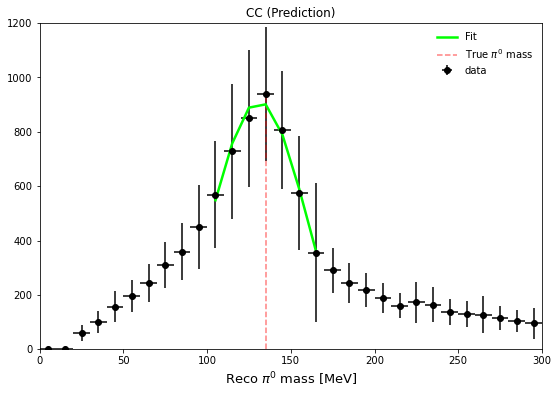

In [30]:
range_left = 100
range_right = 170
ix = np.where((bins_ >= range_left) & (bins_ <= range_right))

data_hist_range = np.asarray(data_mcCC)[ix]
err_bar_range = np.asarray(yerr_mcCC)[ix]
mid_range = np.asarray(bins_)[ix]

pfit, perr, chisq, chisq_red = fit_curvefit([10, 2.0, 140, 3.0], mid_range, data_hist_range, ff, err_bar_range)

print("\n# Fit parameters and parameter errors from curve_fit method :")
print("pfit = ", pfit)
print("perr = ", perr)
print("chisq = ", chisq)
print("chisq_red = ", chisq_red)

plt.figure(figsize=(9,6))
plt.title('CC (Prediction)')
plt.errorbar(bins_, data_mcCC, xerr=xerr, yerr=yerr_mcCC, color='black', label='data', fmt='o')
plt.plot(bins_[ix], fit_function(bins_[ix], *pfit), color='lime', linewidth=2.5, label=r'Fit')
plt.vlines(134.9766, 0, max(data_mcCC)+5, ls='--', color='red', label=r'True $\pi^{0}$ mass', alpha=0.5)
plt.xlabel(r'Reco $\pi^{0}$ mass [MeV]')
plt.ylim(0,1200)
plt.xlim(0,300)
plt.legend(loc='best')
plt.show()